In [0]:
import torch
import numpy as np
import pandas as pd
import pickle
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import models, transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

import os
from sklearn.model_selection import train_test_split

from sklearn.metrics import f1_score

torch.manual_seed(42)
np.random.seed(42)

In [0]:
!nvidia-smi
torch.cuda.is_available()

In [0]:
# скачивание датасета

# !wget https://ky3he4ik.dev/kaggle/simpsons/journey-springfield.zip
# !unzip -u journey-springfield.zip

# Импорт путей

In [0]:
DATA_PATH = '/kaggle/input/journeyspringfield'
RESULT_PATH = '/kaggle/working'
os.chdir('/kaggle/working')

# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)
            self.labels_idxs = self.label_encoder.transform(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):    
        # трансформации    
        data_transforms = {
            'train': transforms.Compose([
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(25),
                transforms.RandomResizedCrop(RESCALE_SIZE, scale=(0.08, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=2),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]),
            'val': transforms.Compose([
                transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]),
            'test': transforms.Compose([
                transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]),
        }        
                
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        x = self.load_sample(self.files[index])
        x = data_transforms[self.mode](x)
        
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

        
def get_sampler(dataset, log_counts=False):
    """
    функция возвращает семплер, для балансировки класса
    """
    target = dataset.labels_idxs
    class_sample_counts = np.unique(target, return_counts=True)[1]
    if log_counts:
        class_sample_counts = np.log(class_sample_counts)
    weight = 1. / torch.tensor(class_sample_counts, dtype=torch.float)
    samples_weight = weight[target]
    sampler = WeightedRandomSampler(samples_weight, len(samples_weight))
    return sampler
    
    
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [0]:
# создание датасетов

TRAIN_DIR = Path(os.path.join(DATA_PATH, 'train/simpsons_dataset'))
TEST_DIR = Path(os.path.join(DATA_PATH, 'testset/testset'))

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))


# разбиваем на трейн и тест
train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

train_dataset = SimpsonsDataset(train_files, mode='train')
val_dataset = SimpsonsDataset(val_files, mode='val')

In [0]:
# функции для тренировки сеток

def fit_epoch(model, train_loader, criterion, optimizer, scheduler=None):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if scheduler is not None:
            scheduler.step()

        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc


def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc


def train(train_files, val_files, model, epochs, batch_size, optimizer, scheduler, epoch_name=''):   
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, sampler=get_sampler(train_dataset), shuffle=False, num_workers=os.cpu_count()
    )
    val_loader = DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, num_workers=os.cpu_count()
    )

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
       
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, optimizer, scheduler)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
            # сохраняем веса каждые 5 эпох
            if not (epoch+1) % 5:
                torch.save(model.state_dict(), os.path.join(RESULT_PATH, 'model_weights_{}_{}.pth'.format(epoch_name, epoch+1)))
            
    return history


def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

# ResNet34

In [0]:
# посмотрим что из себя представляет ResNet34
print(models.resnet34(pretrained=True))

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
n_classes = len(set(train_val_labels))
print("we will classify :{}".format(n_classes))

we will classify :42


In [0]:
torch.manual_seed(42)
np.random.seed(42)

model_resnet34 = models.resnet34(pretrained=True)
    
# Unfreeze the last block of convolutional layers (out of 5 blocks in total)
for child in list(model_resnet34.children())[:-3]:
    for param in child.parameters():
        param.requires_grad = False

# Replace the last FC layer with a FC layer with the correct number of classes
num_ftrs = model_resnet34.fc.in_features
model_resnet34.fc = nn.Linear(num_ftrs, 42)

# Send the model to GPU
model_resnet34 = model_resnet34.to(DEVICE)

In [0]:
# посмотрим какие параметры нейросети мы учим
params_to_update = model_resnet34.parameters()
print("Params to learn:")

params_to_update = []
for name,param in model_resnet34.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 layer4.0.conv1.weight
	 layer4.0.bn1.weight
	 layer4.0.bn1.bias
	 layer4.0.conv2.weight
	 layer4.0.bn2.weight
	 layer4.0.bn2.bias
	 layer4.0.downsample.0.weight
	 layer4.0.downsample.1.weight
	 layer4.0.downsample.1.bias
	 layer4.1.conv1.weight
	 layer4.1.bn1.weight
	 layer4.1.bn1.bias
	 layer4.1.conv2.weight
	 layer4.1.bn2.weight
	 layer4.1.bn2.bias
	 layer4.2.conv1.weight
	 layer4.2.bn1.weight
	 layer4.2.bn1.bias
	 layer4.2.conv2.weight
	 layer4.2.bn2.weight
	 layer4.2.bn2.bias
	 fc.weight
	 fc.bias


Обучение

In [0]:
%%time

optimizer = torch.optim.SGD(model_resnet34.parameters(),lr=1e-3,momentum=0.9)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer,base_lr=1e-3,max_lr=1e-1,step_size_up=2000)
history = train(
    train_dataset, val_dataset, model=model_resnet34, epochs=50, batch_size=350, 
    optimizer=optimizer, scheduler=scheduler, epoch_name='last_block'
)

Построим графики

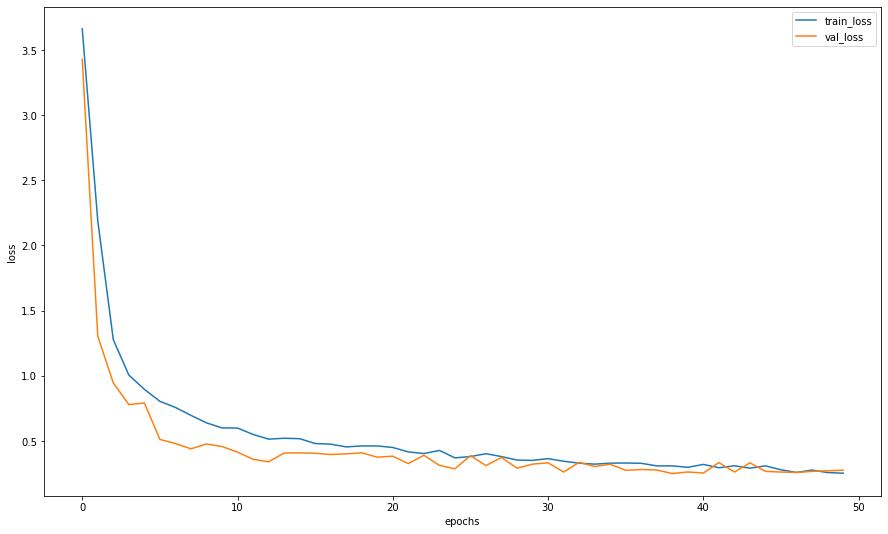

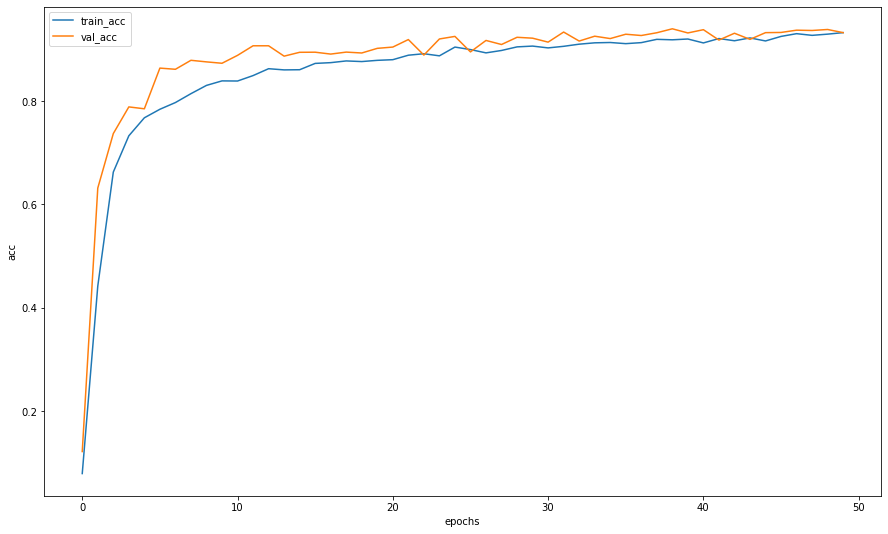

In [0]:
loss, acc, val_loss, val_acc = zip(*history)

plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

plt.figure(figsize=(15, 9))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("acc")
plt.show()

In [0]:
# получаем реальные id меток
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))
actual_class = val_dataset.labels

# делаем предсказание
probs_ims_resnet34 = predict(model_resnet34, [val_dataset[id][0].unsqueeze(0) for id in np.arange(val_dataset.__len__())])
y_pred = np.argmax(probs_ims_resnet34,-1)
preds_class = [label_encoder.classes_[i] for i in y_pred]

In [0]:
# доля верной классификации для каждого класса
actual_preds = pd.DataFrame(zip(actual_class, preds_class), columns=['actual', 'preds'])
actual_preds['res'] = actual_preds.eval('actual == preds')
actual_preds = actual_preds.groupby('actual')['res'].mean().sort_values().reset_index().rename(columns={'actual': 'name'})
actual_preds

,name,res
0,fat_tony,0.428571
1,disco_stu,0.500000
2,gil,0.714286
3,carl_carlson,0.750000
4,cletus_spuckler,0.750000
5,miss_hoover,0.750000
6,barney_gumble,0.769231
7,martin_prince,0.777778
8,patty_bouvier,0.777778
9,snake_jailbird,0.785714


In [0]:
score = f1_score(val_dataset.labels_idxs, y_pred,average='micro')
print('f1_score:', score)

f1_score: 0.9319831868551777


# VGG16

In [0]:
print(models.vgg16(pretrained=True))

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
torch.manual_seed(42)
np.random.seed(42)

model_vgg16 = models.vgg16(pretrained=True)

# хотел разморозить только три последних слоя, по факту разморозил все, кроме первых двух слоев классификатора
layers_to_unfreeze = 3
for param in model_vgg16.classifier[:-layers_to_unfreeze].parameters():
    param.requires_grad = False

#modify the output layer
model_vgg16.classifier[6] = nn.Linear(4096,42)

# Send the model to GPU
model_vgg16 = model_vgg16.to(DEVICE)

In [0]:
# посмотрим какие параметры нейросети мы учим
params_to_update = model_vgg16.parameters()
print("Params to learn:")

params_to_update = []
for name,param in model_vgg16.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 features.0.weight
	 features.0.bias
	 features.2.weight
	 features.2.bias
	 features.5.weight
	 features.5.bias
	 features.7.weight
	 features.7.bias
	 features.10.weight
	 features.10.bias
	 features.12.weight
	 features.12.bias
	 features.14.weight
	 features.14.bias
	 features.17.weight
	 features.17.bias
	 features.19.weight
	 features.19.bias
	 features.21.weight
	 features.21.bias
	 features.24.weight
	 features.24.bias
	 features.26.weight
	 features.26.bias
	 features.28.weight
	 features.28.bias
	 classifier.6.weight
	 classifier.6.bias


In [0]:
# очистка кэша видеокарты
torch.cuda.empty_cache()

Обучение

In [0]:
%%time

optimizer = torch.optim.SGD(model_vgg16.parameters(),lr=1e-3,momentum=0.9)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer,base_lr=1e-3,max_lr=1e-1,step_size_up=2000)
history_vgg16 = train(
    train_dataset, val_dataset, model=model_vgg16, epochs=30, batch_size=128, 
    optimizer=optimizer, scheduler=scheduler, epoch_name='model_vgg16'
)

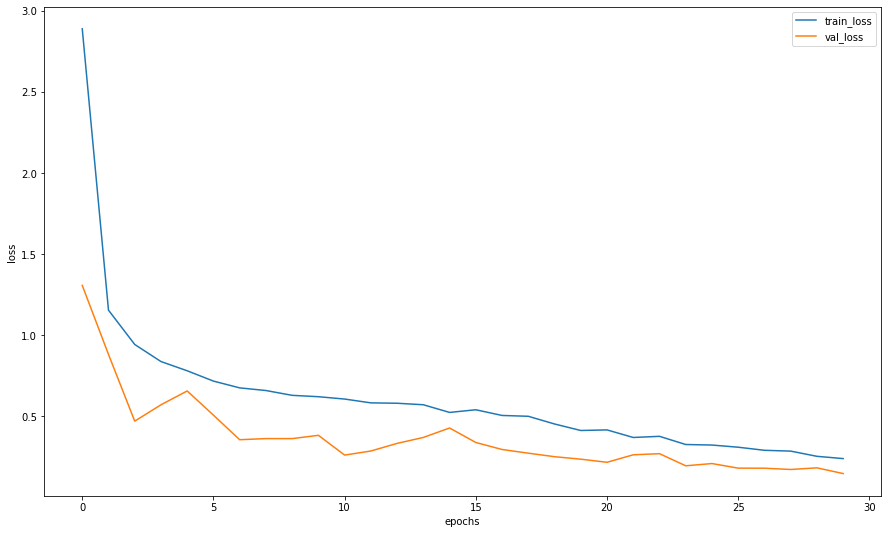

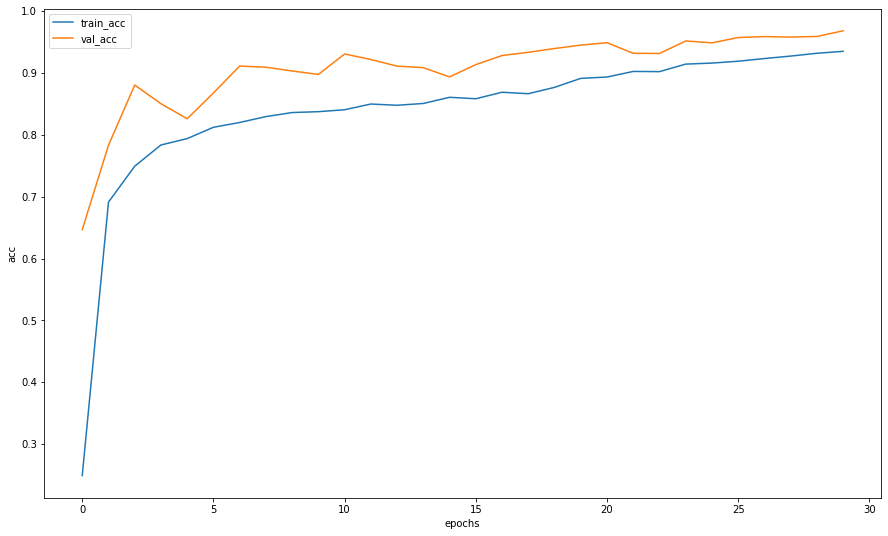

In [0]:
loss, acc, val_loss, val_acc = zip(*history_vgg16)

plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

plt.figure(figsize=(15, 9))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("acc")
plt.show()

In [0]:
# получаем реальные id меток
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))
actual_class = val_dataset.labels

# делаем предсказание
probs_ims_vgg = predict(model_vgg16, [val_dataset[id][0].unsqueeze(0) for id in np.arange(val_dataset.__len__())])
y_pred = np.argmax(probs_ims_vgg,-1)
preds_class = [label_encoder.classes_[i] for i in y_pred]

In [0]:
# доля верной классификации для каждого класса
actual_preds = pd.DataFrame(zip(actual_class, preds_class), columns=['actual', 'preds'])
actual_preds['res'] = actual_preds.eval('actual == preds')
actual_preds = actual_preds.groupby('actual')['res'].mean().sort_values().reset_index().rename(columns={'actual': 'name'})
actual_preds

,name,res
0,disco_stu,0.500000
1,fat_tony,0.571429
2,martin_prince,0.611111
3,miss_hoover,0.750000
4,professor_john_frink,0.812500
5,rainier_wolfcastle,0.818182
6,gil,0.857143
7,otto_mann,0.875000
8,barney_gumble,0.884615
9,nelson_muntz,0.887640


In [0]:
score = f1_score(val_dataset.labels_idxs, y_pred,average='micro')
print('f1_score:', score)

f1_score: 0.9680932365303783


# ResNet34 + VGG16

In [0]:
# строим ансамбль из двух сеток

probs_ims_all = (probs_ims_vgg + probs_ims_resnet34) / 2
y_pred = np.argmax(probs_ims_all,-1)
preds_class = [label_encoder.classes_[i] for i in y_pred]

In [0]:
# доля верной классификации для каждого класса
actual_preds = pd.DataFrame(zip(actual_class, preds_class), columns=['actual', 'preds'])
actual_preds['res'] = actual_preds.eval('actual == preds')
actual_preds = actual_preds.groupby('actual')['res'].mean().sort_values().reset_index().rename(columns={'actual': 'name'})
actual_preds

,name,res
0,disco_stu,0.500000
1,fat_tony,0.571429
2,miss_hoover,0.750000
3,martin_prince,0.777778
4,snake_jailbird,0.857143
5,gil,0.857143
6,otto_mann,0.875000
7,professor_john_frink,0.875000
8,barney_gumble,0.884615
9,patty_bouvier,0.888889


In [0]:
score = f1_score(val_dataset.labels_idxs, y_pred,average='micro')
print('f1_score:', score)

f1_score: 0.9726786396637371


качество немного улучшилось

# Визуализация

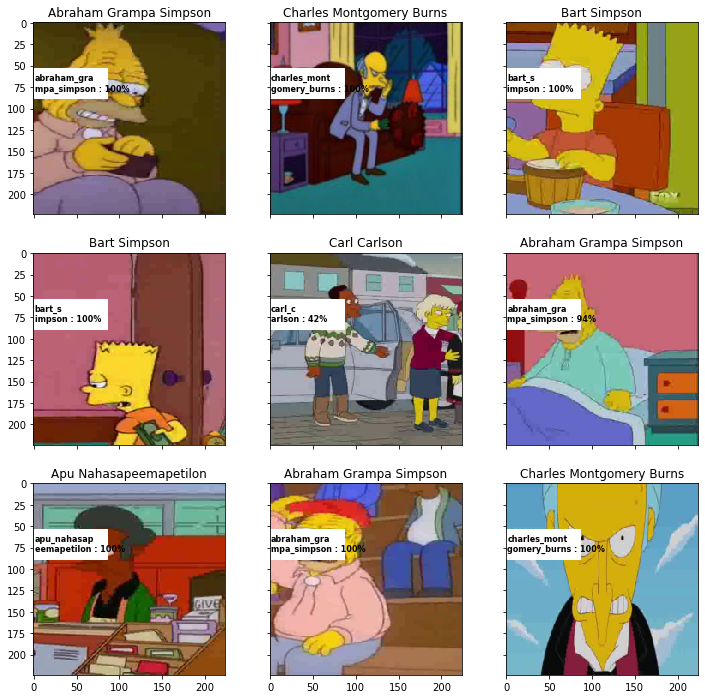

In [0]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred_resnet34 = predict_one_sample(model_resnet34, im_val.unsqueeze(0))
    prob_pred_vgg16 = predict_one_sample(model_vgg16, im_val.unsqueeze(0))
    prob_pred = (prob_pred_resnet34 + prob_pred_vgg16) / 2
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

# Валидация

In [0]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=128)
probs_resnet34 = predict(model_resnet34, test_loader)
probs_vgg16 = predict(model_vgg16, test_loader)
probs = probs_resnet34 + probs_vgg16

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [0]:
# ДОБАВЛЕНО: создание сабмита
import pandas as pd
df = pd.DataFrame()
df['Id'] = test_filenames
df['Expected'] = preds
df.to_csv(os.path.join(RESULT_PATH, 'simpsons_resnet34_vgg16.csv'), index=False)